# Age Estimation and Gender Classification

In this assignment, you will train CNN models to estimate a person's age and gender by given a face image. Please read carefully all the instructions before you start to write your code.

**Your tasks**

You need train two CNN models:
- one is defined by you with a few restrictions and be trained from scratch, save it as `age_gender_A.h5`
- the other is to finetune a pretrained model, save it as `age_gender_B.h5`

**Dataset**

Your models will be trained and validated on a folder `train_val/` containing 5,000 labeled face images (size: 128 x 128), originated from the UTKFace dataset. During marking, your code will be tested on unseen test data. 

**Performance metric**

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy

**Please use the GPU time wisely.**

Just be aware that there is some limit of free GPU usage (It is said the users can use up to 12 hours in row. But many people found they reached its limit far less than 12 hours.). Therefore, I would give you three suggestions to mimimise the risk of reaching the limit.

1. Make sure you have a stable internet connection.
2. Double check all the hyperparameters are good before you start to train the model.
3. According to my experience, each model should be trained in less than 2 hours. If much longer than that, you'd better consider adjusting the architecture.

## Setting Up: Mount the google drive
Mount your google drive to the notebook. 

Also don't forget to **enable GPU** before your training.


in bash shell in the current working directory type 

```bash
unzip train_val-20240219T160046Z-001.zip && rm train_val-20240219T160046Z-001
```

In [2]:
#
# Add your code here
#
# from google.colab import drive

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
# drive.mount('/content/drive')
# paths=['/content/drive/MyDrive/train_val']


# set this to the path where you unzip the Google Driver zip download
# in bash shell in the current working directory type `unzip train_val-20240219T160046Z-001.zip && rm train_val-20240219T160046Z-001`
path='./train_val'

pixels = []
ages = []
genders = [] 

files = os.listdir(path)
i=0
for img in files:
  i=i+1
  gender = img.split("_")[1]
  age = img.split("_")[0]
  if gender != '0' and gender != '1':
    print(img)
  img = cv2.imread(str(path)+"/"+str(img))
  img=cv2.resize(img,(128,128))
  pixels.append(np.array(img))
  genders.append(np.array(gender))
  ages.append(np.array(age))
    # if i == 100:
    #   break
pixels = np.array(pixels,np.float32)
genders = np.array(genders,np.int64)
ages = np.array(ages,np.int64)

## Visualize a few photos
It is always benificial to know your data well before you start. Here display a few (at least 20) images together with its corresponding age and gender from the `train_val/` folder to have a first impression of the dataset. You may also check what the size of the images are.

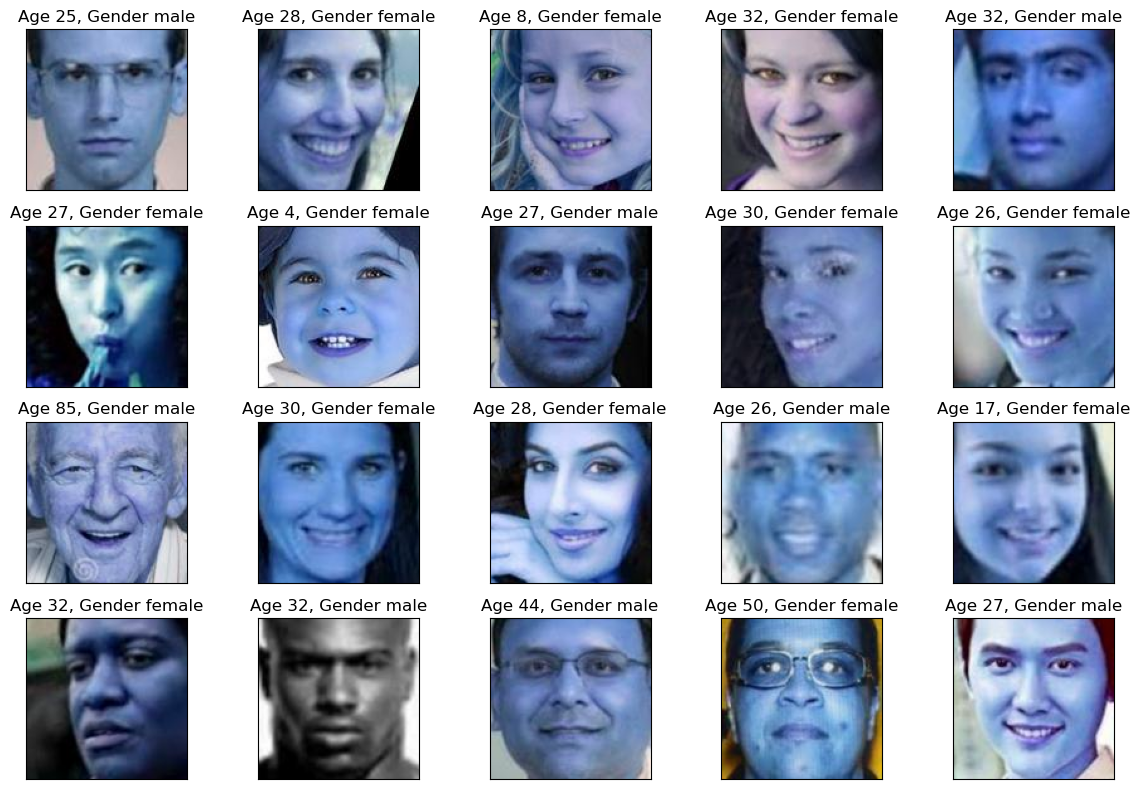

In [14]:
#
# Add your code here
# why would you ever do the plotting/display before ## STEP1: Data pre-processing
# imshow only works on data scaled between 0 and 1 so do pre-processing first
pixels2 = pixels/255

my_arr = np.array(range(0,20)).reshape((4,5))
gender_dict = {0:'male', 1:'female'}
fig, ax = plt.subplots(4, 5, figsize=(12,8))

for i in range(0,4):
  for j in range(0,5):
    ax[i][j].set_xticks([])
    ax[i][j].set_yticks([])
    ax[i][j].grid(False)
    ax[i][j].imshow(pixels2[my_arr[i][j]])
    ax[i][j].set_title("Age %d, Gender %s" % (ages[my_arr[i][j]], gender_dict[genders[my_arr[i][j]]]))
fig.tight_layout()

## Rearrange the dataset
You may do any arrangement for the dataset to suit your later process, such as splitting into training set and validation set, saving the gender labels and age some how, and so on.


In [4]:
#
# Add your code here
#
from sklearn.model_selection import train_test_split

(x_train, x_test,
 y_train_gender, y_test_gender,
 y_train_age, y_test_age) = train_test_split(pixels,genders,ages,random_state=100,train_size=0.8)



## STEP1: Data pre-processing
Now you need do some pre-processing before feeding data into a CNN network. You may consider:

1.	Rescale the pixel values (integers between 0 and 255) to [0,1]. **You must do this rescaling.** Otherwise the testing performance will be affected significantly, as the test images will be rescaling in this way. 
2.	Data augmentation.

**Don't rescale the age to [0,1].** Otherwise the testing performance will be affected significantly, as the original age is used in the testing stage. 

[data_augmenter](https://github.com/berkayalan/neural-networks-and-deep-learning/blob/master/Transfer_learning_with_MobileNet_v1.ipynb)

In [5]:

x_train=x_train/255
x_test=x_test/255

# we can test augmenting later but not sure we want/need to

## STEP2A: Build your own CNN network
Define your own CNN for classifying the gender and predicting the age. Though there are two tasks, you need **only one CNN model, but with two outputs** - you may search online for solution.

There are a few restrictions about your network as follows.
1.	The input size must be 128 x 128 x 3, which means you **should not resize** the original images. This is because my test code relies on this particular input size. Any other size will cause problem in the testing stage.
2.  Please treat the gender classification as a binary problem, i.e., **the output layer for the gender branch has only 1 unit**, instead of 2 (though it is correct to treat the gender classification as a mutli-class problem where class number is 2, the last layer has 2 units). This is because my test code only works for the 1-unit-last-layer gender branch setting. 
3.	The size of feature maps being fed to the first fully connected layer must be less than 10 x 10, while there is no number limitation about the depth.
4.	You may choose any techniques for preventing overfitting. 

In the end of the cell, use `modelA.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.

In [5]:
# input_shape = (36, 36, 3)
# inputs = Input(shape=input_shape)
# no_of_conv_layers=(16,32)
# x=inputs

#     # for i in no_of_conv_layers:

# x=Conv2D(filters=9, kernel_size=(11,11), padding='valid', strides=(1, 1), kernel_regularizer=l2(0.001))(x)
# # x=Activation('relu')(x)
# # x=BatchNormalization(axis=-1)(x)
# # x=MaxPooling2D(pool_size = (2,2))(x)
# # x=Dropout(0.1)(x)
# x


In [6]:
# Import dependencies
import tensorflow as tf
import pandas as pd
# from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPooling2D,Dense,Dropout,BatchNormalization,Flatten,Input,GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint


def make_upstream(inputs, no_of_conv_layers=(16,32)):
    x=inputs

    for i in no_of_conv_layers:
        x=Conv2D(filters=i, kernel_size=(3,3), padding='same', strides=(1, 1), kernel_regularizer=l2(0.001))(x)
        x=Activation('relu')(x)
        x=BatchNormalization(axis=-1)(x)
        x=MaxPooling2D(pool_size = (2,2))(x)
        x=Dropout(0.1)(x)

    return x


def build_age_branch(inputs, no_of_conv_layers=(16,32)):
    x=make_upstream(inputs, no_of_conv_layers)
    x=Flatten()(x)
    x=Dense(128,activation='relu')(x)
    x=Dropout(0.2)(x)
    x=Dense(1)(x)
    x=Activation("linear", name="age_output")(x)
    
    return x


def build_gender_branch(inputs, no_of_conv_layers=(16,32)):

    x=make_upstream(inputs, no_of_conv_layers)
    x=Flatten()(x)
    x=Dense(128,activation='relu')(x)
    x=Dropout(0.2)(x)
    x=Dense(1)(x)
    x=Activation("sigmoid", name="gender_output")(x)

    
    return x

input_shape = (128, 128, 3)
inputs = Input(shape=input_shape)
age_branch = build_age_branch(inputs, no_of_conv_layers=(16,32,64))
gender_branch = build_gender_branch(inputs, no_of_conv_layers=(16,32,64))

modelA = Model(inputs=inputs,
               outputs = [gender_branch,age_branch],
               name="faces")
modelA.summary()

2024-02-22 16:53:09.212336: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-22 16:53:09.363224: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-22 16:53:09.363282: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-22 16:53:09.383458: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-22 16:53:09.427091: I tensorflow/core/platform/cpu_feature_guar

Model: "faces"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 128, 128, 16)         448       ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         448       ['input_1[0][0]']             
                                                                                                  
 activation_3 (Activation)   (None, 128, 128, 16)         0         ['conv2d_3[0][0]']            
                                                                                              

2024-02-22 16:53:12.014112: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-22 16:53:12.083007: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-22 16:53:12.083174: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [7]:
import tensorflow as tf

tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## STEP3A: Compile and train your model
Compile and train your model here. 
Save your model by `modelA.save(your_model_folder+"age_gender_A.h5")` after training. 

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Save the model with `save()` instead of `save_weights()`.** This is because I will load the model by 

`modelA = load_model(model_folder+"age_gender_A.h5")`. 


In [9]:
#
# Add your code here
#-
num_epochs=25
model_folder='output/'
checkpointer = ModelCheckpoint(model_folder, monitor='loss', verbose=1, save_best_only=True,
                               save_weights_only=False, mode='auto', save_freq='epoch')
callback_list=[checkpointer]

modelA.compile(optimizer=Adam(),loss={'gender_output':'binary_crossentropy',
                                      'age_output':'mse'},
               metrics={'gender_output':'accuracy',
                        'age_output':'mae'})
modelA.fit(x=x_train,
           y={"gender_output": y_train_gender, "age_output": y_train_age},
           validation_data=(x_test,{"gender_output": y_test_gender, "age_output": y_test_age}),
           epochs=num_epochs, callbacks=[callback_list], batch_size=8)

# modelA.save(model_folder+"age_gender_A.h5")

Epoch 1/25


2024-02-22 16:57:46.336312: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infaces/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


500/500 [==============================] - ETA: 0s - loss: 75.6154 - gender_output_loss: 0.1838 - age_output_loss: 75.2686 - gender_output_accuracy: 0.9310 - age_output_mae: 6.6384
Epoch 1: loss improved from inf to 75.61540, saving model to output/
INFO:tensorflow:Assets written to: output/assets


INFO:tensorflow:Assets written to: output/assets


500/500 [==============================] - 12s 18ms/step - loss: 75.6154 - gender_output_loss: 0.1838 - age_output_loss: 75.2686 - gender_output_accuracy: 0.9310 - age_output_mae: 6.6384 - val_loss: 239.7062 - val_gender_output_loss: 0.9313 - val_age_output_loss: 238.6025 - val_gender_output_accuracy: 0.8140 - val_age_output_mae: 10.9457
Epoch 2/25
498/500 [============================>.] - ETA: 0s - loss: 75.3857 - gender_output_loss: 0.1581 - age_output_loss: 75.0485 - gender_output_accuracy: 0.9325 - age_output_mae: 6.5884
Epoch 2: loss improved from 75.61540 to 75.37659, saving model to output/
INFO:tensorflow:Assets written to: output/assets


INFO:tensorflow:Assets written to: output/assets


500/500 [==============================] - 9s 17ms/step - loss: 75.3766 - gender_output_loss: 0.1584 - age_output_loss: 75.0391 - gender_output_accuracy: 0.9323 - age_output_mae: 6.5929 - val_loss: 168.9774 - val_gender_output_loss: 0.5890 - val_age_output_loss: 168.2031 - val_gender_output_accuracy: 0.8310 - val_age_output_mae: 9.4036
Epoch 3/25
500/500 [==============================] - ETA: 0s - loss: 66.9310 - gender_output_loss: 0.1555 - age_output_loss: 66.5853 - gender_output_accuracy: 0.9373 - age_output_mae: 6.1618
Epoch 3: loss improved from 75.37659 to 66.93097, saving model to output/
INFO:tensorflow:Assets written to: output/assets


INFO:tensorflow:Assets written to: output/assets


500/500 [==============================] - 8s 17ms/step - loss: 66.9310 - gender_output_loss: 0.1555 - age_output_loss: 66.5853 - gender_output_accuracy: 0.9373 - age_output_mae: 6.1618 - val_loss: 152.1625 - val_gender_output_loss: 0.5235 - val_age_output_loss: 151.4429 - val_gender_output_accuracy: 0.8430 - val_age_output_mae: 8.8517
Epoch 4/25
497/500 [============================>.] - ETA: 0s - loss: 60.8009 - gender_output_loss: 0.2350 - age_output_loss: 60.3638 - gender_output_accuracy: 0.9238 - age_output_mae: 5.8223
Epoch 4: loss improved from 66.93097 to 60.80156, saving model to output/
INFO:tensorflow:Assets written to: output/assets


INFO:tensorflow:Assets written to: output/assets


500/500 [==============================] - 9s 17ms/step - loss: 60.8016 - gender_output_loss: 0.2349 - age_output_loss: 60.3644 - gender_output_accuracy: 0.9235 - age_output_mae: 5.8257 - val_loss: 138.1243 - val_gender_output_loss: 0.3397 - val_age_output_loss: 137.5702 - val_gender_output_accuracy: 0.8550 - val_age_output_mae: 8.5756
Epoch 5/25
497/500 [============================>.] - ETA: 0s - loss: 55.8996 - gender_output_loss: 0.1362 - age_output_loss: 55.5464 - gender_output_accuracy: 0.9462 - age_output_mae: 5.6268
Epoch 5: loss improved from 60.80156 to 56.15831, saving model to output/
INFO:tensorflow:Assets written to: output/assets


INFO:tensorflow:Assets written to: output/assets


500/500 [==============================] - 9s 17ms/step - loss: 56.1583 - gender_output_loss: 0.1359 - age_output_loss: 55.8054 - gender_output_accuracy: 0.9465 - age_output_mae: 5.6374 - val_loss: 170.1541 - val_gender_output_loss: 0.4730 - val_age_output_loss: 169.4618 - val_gender_output_accuracy: 0.8480 - val_age_output_mae: 9.1640
Epoch 6/25
498/500 [============================>.] - ETA: 0s - loss: 50.6437 - gender_output_loss: 0.0993 - age_output_loss: 50.3224 - gender_output_accuracy: 0.9568 - age_output_mae: 5.3421
Epoch 6: loss improved from 56.15831 to 50.70636, saving model to output/
INFO:tensorflow:Assets written to: output/assets


INFO:tensorflow:Assets written to: output/assets


500/500 [==============================] - 9s 17ms/step - loss: 50.7064 - gender_output_loss: 0.0991 - age_output_loss: 50.3853 - gender_output_accuracy: 0.9567 - age_output_mae: 5.3450 - val_loss: 119.4468 - val_gender_output_loss: 0.5946 - val_age_output_loss: 118.6277 - val_gender_output_accuracy: 0.8500 - val_age_output_mae: 7.6833
Epoch 7/25
497/500 [============================>.] - ETA: 0s - loss: 54.7170 - gender_output_loss: 0.1096 - age_output_loss: 54.3784 - gender_output_accuracy: 0.9545 - age_output_mae: 5.5168
Epoch 7: loss did not improve from 50.70636
500/500 [==============================] - 7s 14ms/step - loss: 54.9774 - gender_output_loss: 0.1093 - age_output_loss: 54.6391 - gender_output_accuracy: 0.9548 - age_output_mae: 5.5288 - val_loss: 113.4781 - val_gender_output_loss: 0.4841 - val_age_output_loss: 112.7595 - val_gender_output_accuracy: 0.8700 - val_age_output_mae: 7.6411
Epoch 8/25
499/500 [============================>.] - ETA: 0s - loss: 50.2695 - gender_o

INFO:tensorflow:Assets written to: output/assets


500/500 [==============================] - 9s 17ms/step - loss: 50.3157 - gender_output_loss: 0.1519 - age_output_loss: 49.9230 - gender_output_accuracy: 0.9452 - age_output_mae: 5.3476 - val_loss: 149.2779 - val_gender_output_loss: 0.4829 - val_age_output_loss: 148.5461 - val_gender_output_accuracy: 0.8700 - val_age_output_mae: 8.8401
Epoch 9/25
497/500 [============================>.] - ETA: 0s - loss: 48.7400 - gender_output_loss: 0.0921 - age_output_loss: 48.3964 - gender_output_accuracy: 0.9623 - age_output_mae: 5.2098
Epoch 9: loss improved from 50.31573 to 48.73268, saving model to output/
INFO:tensorflow:Assets written to: output/assets


INFO:tensorflow:Assets written to: output/assets


500/500 [==============================] - 9s 17ms/step - loss: 48.7327 - gender_output_loss: 0.0919 - age_output_loss: 48.3894 - gender_output_accuracy: 0.9622 - age_output_mae: 5.2086 - val_loss: 187.6661 - val_gender_output_loss: 0.4898 - val_age_output_loss: 186.9218 - val_gender_output_accuracy: 0.8710 - val_age_output_mae: 9.5396
Epoch 10/25
497/500 [============================>.] - ETA: 0s - loss: 46.8987 - gender_output_loss: 0.0827 - age_output_loss: 46.5582 - gender_output_accuracy: 0.9625 - age_output_mae: 5.1179
Epoch 10: loss improved from 48.73268 to 46.74923, saving model to output/
INFO:tensorflow:Assets written to: output/assets


INFO:tensorflow:Assets written to: output/assets


500/500 [==============================] - 8s 17ms/step - loss: 46.7492 - gender_output_loss: 0.0835 - age_output_loss: 46.4080 - gender_output_accuracy: 0.9625 - age_output_mae: 5.1078 - val_loss: 129.3857 - val_gender_output_loss: 0.5118 - val_age_output_loss: 128.6120 - val_gender_output_accuracy: 0.8480 - val_age_output_mae: 7.9767
Epoch 11/25
498/500 [============================>.] - ETA: 0s - loss: 46.6489 - gender_output_loss: 0.0972 - age_output_loss: 46.2856 - gender_output_accuracy: 0.9634 - age_output_mae: 5.1387
Epoch 11: loss improved from 46.74923 to 46.54933, saving model to output/
INFO:tensorflow:Assets written to: output/assets


INFO:tensorflow:Assets written to: output/assets


500/500 [==============================] - 9s 18ms/step - loss: 46.5493 - gender_output_loss: 0.0976 - age_output_loss: 46.1857 - gender_output_accuracy: 0.9628 - age_output_mae: 5.1333 - val_loss: 131.0395 - val_gender_output_loss: 0.5415 - val_age_output_loss: 130.2265 - val_gender_output_accuracy: 0.8530 - val_age_output_mae: 8.0336
Epoch 12/25
496/500 [============================>.] - ETA: 0s - loss: 44.1881 - gender_output_loss: 0.0798 - age_output_loss: 43.8338 - gender_output_accuracy: 0.9685 - age_output_mae: 4.9836
Epoch 12: loss improved from 46.54933 to 44.17584, saving model to output/
INFO:tensorflow:Assets written to: output/assets


INFO:tensorflow:Assets written to: output/assets


500/500 [==============================] - 8s 17ms/step - loss: 44.1758 - gender_output_loss: 0.0797 - age_output_loss: 43.8217 - gender_output_accuracy: 0.9685 - age_output_mae: 4.9831 - val_loss: 215.9379 - val_gender_output_loss: 0.5534 - val_age_output_loss: 215.1057 - val_gender_output_accuracy: 0.8580 - val_age_output_mae: 10.7784
Epoch 13/25
498/500 [============================>.] - ETA: 0s - loss: 46.1020 - gender_output_loss: 0.0915 - age_output_loss: 45.7266 - gender_output_accuracy: 0.9691 - age_output_mae: 5.0880
Epoch 13: loss did not improve from 44.17584
500/500 [==============================] - 7s 14ms/step - loss: 46.1290 - gender_output_loss: 0.0919 - age_output_loss: 45.7531 - gender_output_accuracy: 0.9690 - age_output_mae: 5.0926 - val_loss: 227.5002 - val_gender_output_loss: 0.5915 - val_age_output_loss: 226.6203 - val_gender_output_accuracy: 0.8610 - val_age_output_mae: 10.4514
Epoch 14/25
497/500 [============================>.] - ETA: 0s - loss: 45.4861 - gen

INFO:tensorflow:Assets written to: output/assets


500/500 [==============================] - 9s 17ms/step - loss: 42.3292 - gender_output_loss: 0.0661 - age_output_loss: 41.9405 - gender_output_accuracy: 0.9735 - age_output_mae: 4.8325 - val_loss: 114.3943 - val_gender_output_loss: 0.6967 - val_age_output_loss: 113.3718 - val_gender_output_accuracy: 0.8670 - val_age_output_mae: 7.5327
Epoch 18/25
499/500 [============================>.] - ETA: 0s - loss: 41.0647 - gender_output_loss: 0.0865 - age_output_loss: 40.6475 - gender_output_accuracy: 0.9689 - age_output_mae: 4.7259
Epoch 18: loss improved from 42.32917 to 41.02443, saving model to output/
INFO:tensorflow:Assets written to: output/assets


INFO:tensorflow:Assets written to: output/assets


500/500 [==============================] - 9s 18ms/step - loss: 41.0244 - gender_output_loss: 0.0863 - age_output_loss: 40.6074 - gender_output_accuracy: 0.9690 - age_output_mae: 4.7245 - val_loss: 115.6612 - val_gender_output_loss: 0.9413 - val_age_output_loss: 114.3832 - val_gender_output_accuracy: 0.8440 - val_age_output_mae: 7.6761
Epoch 19/25
499/500 [============================>.] - ETA: 0s - loss: 41.6279 - gender_output_loss: 0.0699 - age_output_loss: 41.2183 - gender_output_accuracy: 0.9724 - age_output_mae: 4.7933
Epoch 19: loss did not improve from 41.02443
500/500 [==============================] - 7s 14ms/step - loss: 41.5758 - gender_output_loss: 0.0698 - age_output_loss: 41.1663 - gender_output_accuracy: 0.9725 - age_output_mae: 4.7898 - val_loss: 144.8412 - val_gender_output_loss: 0.6096 - val_age_output_loss: 143.8886 - val_gender_output_accuracy: 0.8620 - val_age_output_mae: 8.4176
Epoch 20/25
498/500 [============================>.] - ETA: 0s - loss: 38.3157 - gende

INFO:tensorflow:Assets written to: output/assets


500/500 [==============================] - 9s 17ms/step - loss: 38.4798 - gender_output_loss: 0.0776 - age_output_loss: 38.0559 - gender_output_accuracy: 0.9672 - age_output_mae: 4.6232 - val_loss: 107.9656 - val_gender_output_loss: 0.8839 - val_age_output_loss: 106.7308 - val_gender_output_accuracy: 0.8570 - val_age_output_mae: 7.3917
Epoch 21/25
497/500 [============================>.] - ETA: 0s - loss: 40.8488 - gender_output_loss: 0.0718 - age_output_loss: 40.4205 - gender_output_accuracy: 0.9708 - age_output_mae: 4.7129
Epoch 21: loss did not improve from 38.47980
500/500 [==============================] - 7s 14ms/step - loss: 40.9143 - gender_output_loss: 0.0714 - age_output_loss: 40.4864 - gender_output_accuracy: 0.9710 - age_output_mae: 4.7146 - val_loss: 119.2822 - val_gender_output_loss: 0.6540 - val_age_output_loss: 118.2687 - val_gender_output_accuracy: 0.8590 - val_age_output_mae: 7.8003
Epoch 22/25
498/500 [============================>.] - ETA: 0s - loss: 36.9094 - gende

INFO:tensorflow:Assets written to: output/assets


500/500 [==============================] - 9s 17ms/step - loss: 36.9704 - gender_output_loss: 0.0794 - age_output_loss: 36.5270 - gender_output_accuracy: 0.9705 - age_output_mae: 4.5217 - val_loss: 106.3163 - val_gender_output_loss: 0.5248 - val_age_output_loss: 105.4207 - val_gender_output_accuracy: 0.8580 - val_age_output_mae: 7.3169
Epoch 23/25
499/500 [============================>.] - ETA: 0s - loss: 38.3632 - gender_output_loss: 0.0629 - age_output_loss: 37.9260 - gender_output_accuracy: 0.9752 - age_output_mae: 4.6036
Epoch 23: loss did not improve from 36.97036
500/500 [==============================] - 7s 14ms/step - loss: 38.3299 - gender_output_loss: 0.0628 - age_output_loss: 37.8928 - gender_output_accuracy: 0.9753 - age_output_mae: 4.6019 - val_loss: 120.3318 - val_gender_output_loss: 0.7149 - val_age_output_loss: 119.2370 - val_gender_output_accuracy: 0.8760 - val_age_output_mae: 7.9952
Epoch 24/25
500/500 [==============================] - ETA: 0s - loss: 36.8336 - gende

INFO:tensorflow:Assets written to: output/assets


500/500 [==============================] - 8s 17ms/step - loss: 36.8336 - gender_output_loss: 0.0643 - age_output_loss: 36.3862 - gender_output_accuracy: 0.9765 - age_output_mae: 4.5192 - val_loss: 122.4376 - val_gender_output_loss: 0.5352 - val_age_output_loss: 121.5145 - val_gender_output_accuracy: 0.8540 - val_age_output_mae: 7.8460
Epoch 25/25
499/500 [============================>.] - ETA: 0s - loss: 37.0253 - gender_output_loss: 0.0878 - age_output_loss: 36.5449 - gender_output_accuracy: 0.9719 - age_output_mae: 4.5102
Epoch 25: loss did not improve from 36.83360
500/500 [==============================] - 7s 14ms/step - loss: 36.9919 - gender_output_loss: 0.0877 - age_output_loss: 36.5116 - gender_output_accuracy: 0.9720 - age_output_mae: 4.5079 - val_loss: 120.3337 - val_gender_output_loss: 0.6568 - val_age_output_loss: 119.2781 - val_gender_output_accuracy: 0.8680 - val_age_output_mae: 7.8270


In [17]:
model_folder='output/'
modelA = load_model(model_folder+"age_gender_A.h5")
modelA.evaluate(x_test, {"gender_output": y_test_gender, "age_output": y_test_age})

2024-02-20 21:14:22.593213: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902


32/32 [==============================] - 2s 25ms/step - loss: 128.5301 - gender_output_loss: 0.5122 - age_output_loss: 127.8629 - gender_output_accuracy: 0.8760 - age_output_mae: 7.8888


[128.53013610839844,
 0.5122098922729492,
 127.8629379272461,
 0.8759999871253967,
 7.888835906982422]

## STEP4A: Draw the learning curves
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set


In [10]:
# modelA.evaluate(x_test, {"gender_output": y_test_gender, "age_output": y_test_age})
modelA.save(model_folder+"age_gender_A.h5")

/home/coyote/miniconda3/envs/cnn_proj/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


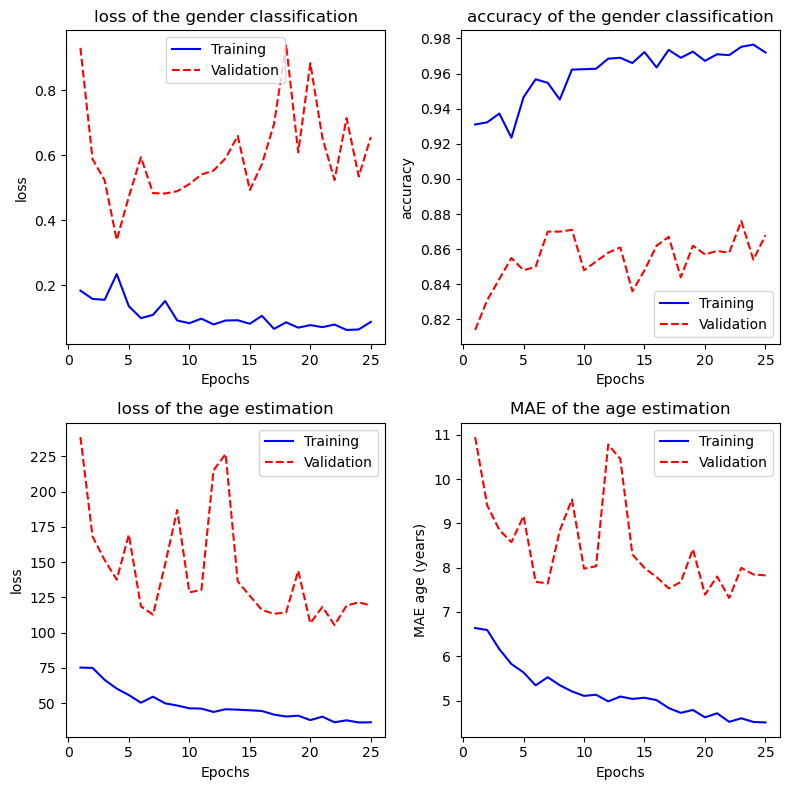

In [11]:
#
# Add your code here
#
history = modelA.history.history
plots = [
    [[history['gender_output_loss'],history['val_gender_output_loss']],
     [history['gender_output_accuracy'],history['val_gender_output_accuracy']]],
    [[history['age_output_loss'],history['val_age_output_loss']],
     [history['age_output_mae'],history['val_age_output_mae']]]
]

y_axis = [['loss', 'accuracy'],
          ['loss', 'MAE age (years)']]

titles = [['loss of the gender classification', 'accuracy of the gender classification'],
          ['loss of the age estimation', 'MAE of the age estimation']]

fig, ax = plt.subplots(2,2, figsize=(8,8))

for i in range(0,2):
    for j in range(0,2):
        ax[i][j].plot(range(1,num_epochs+1),plots[i][j][0], label='Training', linestyle='-', color='blue')
        ax[i][j].plot(range(1,num_epochs+1),plots[i][j][1], label='Validation', linestyle='--', color='red')
        ax[i][j].set_xlabel('Epochs')
        ax[i][j].set_ylabel(y_axis[i][j])
        ax[i][j].set_title(titles[i][j])
        ax[i][j].legend()
fig.tight_layout()

## STEP2B: Build a CNN network based on a pre-trained model 
Choose one existing CNN architecture pre-trained on ImageNet, and fine-tune on this dataset.

The same as required in Model A, **don’t resize the input image size**. **The output layer for the gender branch is set to have only 1 unit**. 

In the end of the cell, use `modelB.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.


In [5]:
# import tensorflow_hub as hub
# import tensorflow as tf
# model_gcs_path = "gs://tfhub-modules/sayakpaul/convnext_tiny_1k_224/1/uncompressed"
# model = tf.keras.models.load_model(model_gcs_path)
# print(model.summary(expand_nested=True))
#
# Add your code here
#
# from google.colab import drive

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
# drive.mount('/content/drive')
# paths=['/content/drive/MyDrive/train_val']


# set this to the path where you unzip the Google Driver zip download
# in bash shell in the current working directory type `unzip train_val-20240219T160046Z-001.zip && rm train_val-20240219T160046Z-001`
path='./train_val'

pixels = []
ages = []
genders = [] 

files = os.listdir(path)
i=0
for img in files:
  i=i+1
  gender = img.split("_")[1]
  age = img.split("_")[0]
  if gender != '0' and gender != '1':
    print(img)
  img = cv2.imread(str(path)+"/"+str(img))
  img=cv2.resize(img,(128,128))
  pixels.append(np.array(img))
  genders.append(np.array(gender))
  ages.append(np.array(age))
    # if i == 100:
    #   break
pixels = np.array(pixels,np.float32)
genders = np.array(genders,np.int64)
ages = np.array(ages,np.int64)

#
# Add your code here
#
from sklearn.model_selection import train_test_split

(x_train, x_test,
 y_train_gender, y_test_gender,
 y_train_age, y_test_age) = train_test_split(pixels,genders,ages,random_state=100,train_size=0.8)

x_train=x_train/255
x_test=x_test/255

# Import dependencies
import tensorflow as tf
import pandas as pd
# from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPooling2D,Dense,Dropout,BatchNormalization,Flatten,Input,GlobalAveragePooling2D, AveragePooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

input_shape = (128, 128, 3)
inputs = Input(shape=input_shape)

model_resnet50 = tf.keras.applications.resnet50.ResNet50(include_top=False, 
                                        weights='imagenet', 
                                        input_tensor=inputs,
                                        input_shape=input_shape, 
                                        pooling=None, 
                                        classes=2,
                                        classifier_activation='softmax',
                                       )
model_resnet50.trainable = False

In [7]:
learning_rate=1e-2
learning_rate

0.01

In [9]:
from tensorflow.keras import layers

img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
]


def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

In [21]:
import tensorflow_datasets as tfds
dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)

/home/coyote/miniconda3/envs/cnn_proj/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-02-25 01:03:54.357684: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Dl Completed...: 100%|██████████| 1/1 [01:27<00:00, 87.64s/ url]
Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...:  50%|█████     | 1/2 [00:02<00:02,  2.91s/ url]

Dl Completed...: 100%|██████████| 2/2 [00:14<00:00,  7.19s/ url]

In [ ]:
x_train.m

In [19]:
# One-hot / categorical encoding
def input_preprocess_train(image):
    image = img_augmentation(image)
    return image


x_train2 = [input_preprocess_train(i) for i in x_train]

KeyboardInterrupt: 

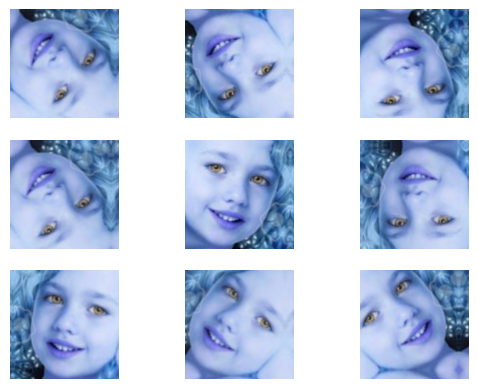

In [18]:
image = x_train[0]
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    aug_img = img_augmentation(np.expand_dims(image, axis=0))
    aug_img = np.array(aug_img)
    plt.imshow(aug_img[0])
    plt.axis("off")

In [3]:
num_epochs=5
model_folder='output/'
checkpointer = ModelCheckpoint(model_folder, monitor='loss', verbose=1, save_best_only=True,
                               save_weights_only=False, mode='auto', save_freq='epoch')
callback_list=[checkpointer]

model_resnet50.compile(optimizer=Adam(),loss='sparse_categorical_crossentropy', metrics='accuracy')

headModel=model_resnet50.output


headModel_gender=AveragePooling2D(pool_size=(4, 4))(headModel)
headModel_gender=Flatten()(headModel_gender)
headModel_gender=Dense(128,activation='relu')(headModel_gender)
headModel_gender=Dropout(0.2)(headModel_gender)
headModel_gender=Dense(1)(headModel_gender)
headModel_gender=Activation("sigmoid", name="gender_output")(headModel_gender)

headModel_age=AveragePooling2D(pool_size=(4, 4))(headModel)
headModel_age=Flatten()(headModel_age)
headModel_age=Dense(128,activation='relu')(headModel_age)
headModel_age=Dropout(0.2)(headModel_age)
headModel_age=Dense(1)(headModel_age)
headModel_age=Activation("linear", name="age_output")(headModel_age)

modelB = Model(inputs=model_resnet50.input, outputs=[headModel_gender, headModel_age])
modelB.compile(optimizer=Adam(learning_rate=1e-2),loss={'gender_output':'binary_crossentropy',
                                      'age_output':'mse'},
               metrics={'gender_output':'accuracy',
                        'age_output':'mae'})
modelB.fit(x=x_train,
           y={"gender_output": y_train_gender, "age_output": y_train_age},
           validation_data=(x_test,{"gender_output": y_test_gender, "age_output": y_test_age}),
           epochs=num_epochs, callbacks=[callback_list], batch_size=8)


# model.compile(optimizer=Adam(),loss='binary_crossentropy', metrics='accuracy')
# # model.summary()

# model.fit(x=x_train,
#            y=y_train_gender,
#            validation_data=(x_test, y_test_gender),
#            epochs=num_epochs, callbacks=[callback_list], batch_size=8)

Epoch 1/5


2024-02-25 00:46:27.638357: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-02-25 00:46:30.114172: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f8507a83540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-25 00:46:30.114216: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-02-25 00:46:30.122178: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1708821990.241148   21510 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


499/500 [============================>.] - ETA: 0s - loss: 473.9051 - gender_output_loss: 0.6963 - age_output_loss: 473.2086 - gender_output_accuracy: 0.5331 - age_output_mae: 16.6079
Epoch 1: loss improved from inf to 475.15054, saving model to output/
INFO:tensorflow:Assets written to: output/assets


INFO:tensorflow:Assets written to: output/assets


500/500 [==============================] - 25s 38ms/step - loss: 475.1505 - gender_output_loss: 0.6963 - age_output_loss: 474.4540 - gender_output_accuracy: 0.5325 - age_output_mae: 16.6276 - val_loss: 398.2266 - val_gender_output_loss: 0.6890 - val_age_output_loss: 397.5377 - val_gender_output_accuracy: 0.5070 - val_age_output_mae: 15.7895
Epoch 2/5
498/500 [============================>.] - ETA: 0s - loss: 400.5500 - gender_output_loss: 0.6902 - age_output_loss: 399.8596 - gender_output_accuracy: 0.5437 - age_output_mae: 15.4583
Epoch 2: loss improved from 475.15054 to 400.60187, saving model to output/
INFO:tensorflow:Assets written to: output/assets


INFO:tensorflow:Assets written to: output/assets


500/500 [==============================] - 18s 36ms/step - loss: 400.6019 - gender_output_loss: 0.6901 - age_output_loss: 399.9115 - gender_output_accuracy: 0.5440 - age_output_mae: 15.4581 - val_loss: 393.4829 - val_gender_output_loss: 0.6862 - val_age_output_loss: 392.7967 - val_gender_output_accuracy: 0.6820 - val_age_output_mae: 15.5947
Epoch 3/5
499/500 [============================>.] - ETA: 0s - loss: 398.2457 - gender_output_loss: 0.6883 - age_output_loss: 397.5575 - gender_output_accuracy: 0.5408 - age_output_mae: 15.3786
Epoch 3: loss improved from 400.60187 to 397.85916, saving model to output/
INFO:tensorflow:Assets written to: output/assets


INFO:tensorflow:Assets written to: output/assets


500/500 [==============================] - 19s 38ms/step - loss: 397.8592 - gender_output_loss: 0.6883 - age_output_loss: 397.1710 - gender_output_accuracy: 0.5408 - age_output_mae: 15.3709 - val_loss: 386.8620 - val_gender_output_loss: 0.6901 - val_age_output_loss: 386.1719 - val_gender_output_accuracy: 0.4940 - val_age_output_mae: 15.2199
Epoch 4/5
500/500 [==============================] - ETA: 0s - loss: 402.7428 - gender_output_loss: 0.6867 - age_output_loss: 402.0556 - gender_output_accuracy: 0.5527 - age_output_mae: 15.4329
Epoch 4: loss did not improve from 397.85916
500/500 [==============================] - 11s 21ms/step - loss: 402.7428 - gender_output_loss: 0.6867 - age_output_loss: 402.0556 - gender_output_accuracy: 0.5527 - age_output_mae: 15.4329 - val_loss: 383.8291 - val_gender_output_loss: 0.6849 - val_age_output_loss: 383.1443 - val_gender_output_accuracy: 0.5190 - val_age_output_mae: 15.0141
Epoch 5/5
498/500 [============================>.] - ETA: 0s - loss: 398.39

In [6]:
#
# Add your code here
#

modelB.summary()
from tensorflow.keras.utils import plot_model
# plot_model(modelB, show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

## STEP3B: Compile and train your model
Compile and train your model here. 
Save your model to `age_gender_B.h5` after training. 

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Also, save the model with `save()` instead of `save_weights()`.** 


In [ ]:
#
# Add your code here
#
model_folder='output/'

modelB.save(model_folder+"age_gender_B.h5")

## STEP4B: Draw the learning curve
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set

In [ ]:
#
# Add your code here
#


## STEP5: Evaluate the model on the test set
I will add my test code here to test the two models you trained. The test set will not be available before your submission. 

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy


In [ ]:
#
# Don't add code in this cell when submitting this file
#